In [1]:
%cd /home/heydar/me/BSC/FinalPorject/lsh

/home/heydar/me/BSC/FinalPorject/lsh


In [2]:
import heapq
import pickle
import random
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from src.Kmeans.kmeans import get_random_state
from src.Kmeans.mh_kmeans import _mhkmeans, mhkmeans
from src.LSH.MinHash import MinHash
from src.LSH.lsh import LSH
from src.utils.storage import HashNodeSet
from time import time


In [3]:
#Load dataset
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)
labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)

In [4]:
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics

In [5]:
# TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)

In [6]:
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 0.471 s


In [7]:
drops_datas=np.where([X_tfidf.getnnz(1)<1])[1]
nnzero_rows=X_tfidf.getnnz(1)>1
labels=labels[nnzero_rows]
X_tfidf=X_tfidf[nnzero_rows]

In [8]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")
shingles = [set(vector[0].nonzero()[1]) for vector in X_tfidf]

0.007


In [21]:
# Create a copy of the CSR matrix and convert it to a COO matrix
coo_matrix = X_tfidf.tocoo(copy=True)

# Replace non-zero values with their own column indices
coo_matrix.data = coo_matrix.col

# Convert the COO matrix back to CSR format
result_matrix = coo_matrix.tocsr()


In [10]:
#set Cluster Number
true_k = 100


In [11]:
X_tfidf.shape[1]

7929

In [12]:
#Make LSH
prime=8017
lsh_time_start=time()
b, r = 5, 2
num_perm = b * r
minhash = MinHash(num_perm)
mh = minhash.sign_csr_callback_permutation(result_matrix, result_matrix.shape[1],prime)
#
mh = np.array(mh)
print('waiting for Create LSH index')
# Create LSH index
lsh = LSH(b=b, r=r)
lsh.fit(mh)
print('LSH index Created')
lsh_time=time()-lsh_time_start

waiting for Create LSH index
LSH index Created


In [14]:
#Make LSH Graph
import networkx as nx
graph_time_start=time()
G = nx.Graph()
_hash_nodes_start = lsh.keys.size() + 10
hash_to_node_map = [HashNodeSet() for _ in range(lsh.b)]
for node in lsh.keys.keys():
    for bi, hash_bi in enumerate(lsh.keys.get(node)):
        hash_node = hash_to_node_map[bi].add(hash_bi)
        G.add_edges_from([(f'p_{node}', f'h_{hash_node}_{bi}')])
graph_time=time()-graph_time_start

In [15]:
random_state=get_random_state()
def generate_cluster_with_graph(k, X, G, type):
    subgraphs = list(nx.connected_components(G))
    centroids = [{} for _ in range(k)]
    if k < len(subgraphs):
        if type == 'max':
            k_max_indices = heapq.nlargest(k, range(len(subgraphs)), key=lambda i: len(subgraphs[i]))
            for ik, kvalue in enumerate(k_max_indices):
                centroids[ik] = [int(p[2:]) for p in subgraphs[kvalue] if p.startswith('p')]
            return np.concatenate([np.asarray(X[cs].mean(axis=0)) for cs in centroids])
        elif type == 'max_rand':
            k_max_indices = heapq.nlargest(k, range(len(subgraphs)), key=lambda i: len(subgraphs[i]))
            for ik, kvalue in enumerate(k_max_indices):
                centroids[ik] = int(random.choice([i[2:] for i in subgraphs[kvalue] if i.startswith('p')]))
            centroids = np.array(centroids)
            return X[centroids].toarray()
        elif type == 'min':
            k_max_indices = heapq.nsmallest(k, range(len(subgraphs)), key=lambda i: len(subgraphs[i]))
            for ik, kvalue in enumerate(k_max_indices):
                centroids[ik] = int(random.choice([i[2:] for i in subgraphs[kvalue] if i.startswith('p')]))
            centroids = np.array(centroids)
            return X[centroids].toarray()
        elif type=='min_rand':
            candidate_sg=[subgraph for subgraph in subgraphs if len(subgraph)==b+1]
            _candidates=[]
            for subgraph in candidate_sg:
                _candidates.append(int([c for c in subgraph if c.startswith('p')][0][2:]))
            if len(_candidates)< k:
                candidates=_candidates
                candidates2 = random_state.choice(
                X.shape[0],
                size=k-len(_candidates),
                replace=False)
                centroids=np.concatenate([candidates,candidates2])
            else:
                seeds = random_state.choice(
                    range(len(_candidates)),
                    size=k,
                    replace=False)
                centroids=[_candidates[s] for s in seeds]
            centroids = np.array(centroids)
            return X[centroids].toarray()
        elif type == 'mix':
            if k == 1:
                return np.asarray([X.mean(axis=0)])
            min_k = int(k / 2)
            max_k = k - min_k
            k_max_indices = heapq.nsmallest(min_k, range(len(subgraphs)), key=lambda i: len(subgraphs[i]))
            for ik, kvalue in enumerate(k_max_indices):
                centroids[ik] = [int(random.choice([i[2:] for i in subgraphs[kvalue] if i.startswith('p')]))]

            k_max_indices = heapq.nlargest(max_k, range(len(subgraphs)), key=lambda i: len(subgraphs[i]))
            for ik, kvalue in enumerate(k_max_indices):
                centroids[min_k + ik] = [int(p[2:]) for p in subgraphs[kvalue] if p.startswith('p')]
            return np.concatenate([np.asarray(X[cs].mean(axis=0)) for cs in centroids])

    return centroids
initializing_time=time()
centroids = generate_cluster_with_graph(true_k, X_tfidf, G, 'min')
initializing_time=time()-initializing_time
initializing_time+=graph_time+lsh_time

In [16]:
def euclidean_distances_square(X,Y):
    return euclidean_distances(X,Y,squared=True)


In [17]:
def fit_and_evaluate(km, X, name=None, n_runs=5,seek_time=0):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time()+seek_time - t0)
        scores['inertia'].append(km.inertia_)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


In [19]:
evaluations = []
evaluations_std = []


from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
    init='random'
)
fit_and_evaluate(kmeans, X_tfidf, name="KMeans random \non  tf-idf vectors", n_runs=10)

print("__________________________")
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,

)
fit_and_evaluate(kmeans, X_tfidf, name="KMeans++\non tf-idf vectors", n_runs=10)
print("__________________________")

kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
    init=centroids
)
fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non LSH",seek_time=initializing_time)


clustering done in 1.29 ± 0.42 s 
inertia: 2926.654 ± 4.260
Homogeneity: 0.455 ± 0.012
Completeness: 0.145 ± 0.004
V-measure: 0.220 ± 0.006
Adjusted Rand-Index: 0.033 ± 0.004
Silhouette Coefficient: 0.013 ± 0.001
__________________________
clustering done in 1.55 ± 0.26 s 
inertia: 2904.939 ± 4.813
Homogeneity: 0.480 ± 0.009
Completeness: 0.153 ± 0.003
V-measure: 0.232 ± 0.005
Adjusted Rand-Index: 0.032 ± 0.002
Silhouette Coefficient: 0.016 ± 0.001
__________________________
clustering done in 4.11 ± 0.03 s 
inertia: 2931.161 ± 0.000
Homogeneity: 0.421 ± 0.000
Completeness: 0.137 ± 0.000
V-measure: 0.206 ± 0.000
Adjusted Rand-Index: 0.030 ± 0.000
Silhouette Coefficient: 0.012 ± 0.000


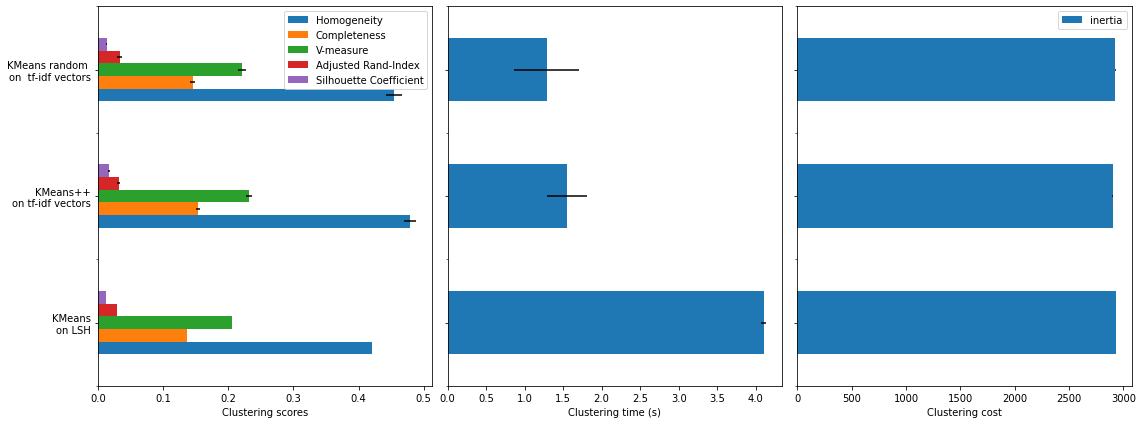

In [20]:


# Plot
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1,ax2) = plt.subplots(ncols=3, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time",'inertia'],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")


df[['inertia']].plot.barh(ax=ax2,xerr=df_std)
ax2.set_xlabel("Clustering cost")
ax2.set_ylabel("")


plt.tight_layout()
plt.show()

